# Imports & Env. Config

In [191]:
!pip install mmcif_pdbx
!pip install pandas-profiling
!pip install pyarrow
!pip install biopython
!pip install plotly
!chmod 777 -R blast/
!chmod 777 -R tmalign/

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import SearchIO

# I/O Libs
from google.cloud import storage
import io
from io import StringIO
import os
from IPython.display import clear_output
from google.cloud.storage import Blob
import shutil

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math
import random
import gzip
import pyarrow as pa
import pyarrow.parquet as pq
import itertools

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()
import plotly

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.datasets import make_blobs

os.environ['PATH'] = '/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/pss/blast/bin:/home/jupyter/pss/tmalign'

clear_output()

In [192]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
storage_client = storage.Client()

# Download List of Filenames (mmCIF) From GCS

In [8]:
path = 'UP000005640_9606_HUMAN/cif/'
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if path in blob.name:
        filenames.append(blob.name[27:].split('.')[0])
print(f'Indexed {len(filenames)} files.')

Indexed 23391 files.


# Set Randomization & Plotting Options

In [4]:
random_seed = 76523
random.seed(random_seed)
color_map = 'inferno'

# Control: BLAST Scores + e-Values for Randomly Clustered Proteins

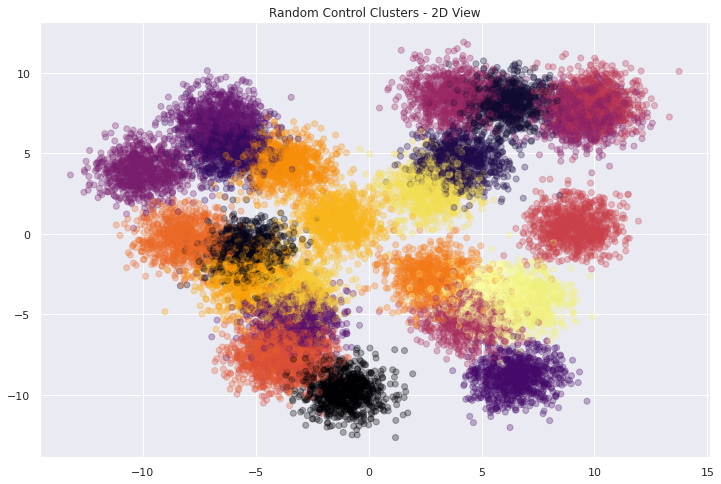

In [42]:
# create random 3D clusters of len(filenames)

fixed_proteins = pd.read_parquet('sequences.parquet')
fixed_proteins.drop(['db_code', 'db_name', 'protein_name', 'pdbx_seq_one_letter_code'], axis=1, inplace=True)
fixed_proteins.columns = ['protein']

X, y = make_blobs(n_samples=len(fixed_proteins), centers=25, n_features=3, random_state=random_seed)

# 2D visualization
figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=color_map)
plt.title('Random Control Clusters - 2D View')
plt.show()

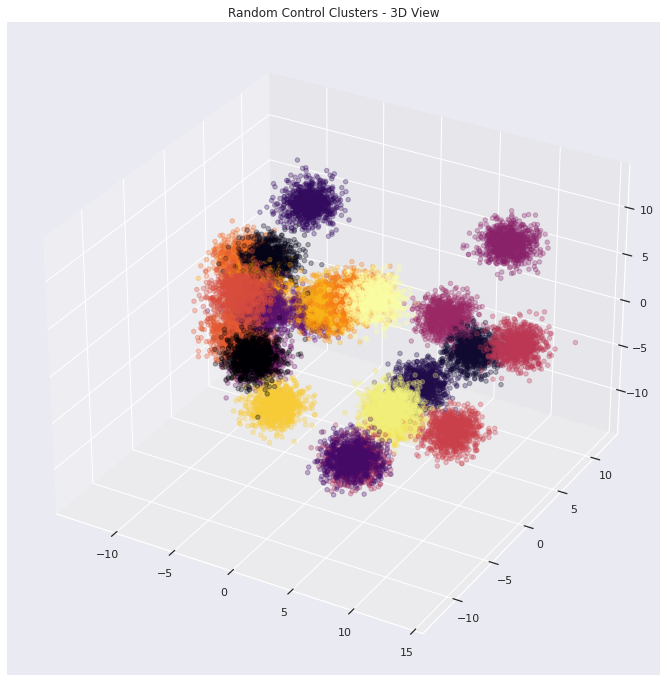

In [43]:
# 3D visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, alpha=0.3, cmap=color_map)
ax.figure.set_size_inches((12,12))
ax.set_title('Random Control Clusters - 3D View')
plt.show()

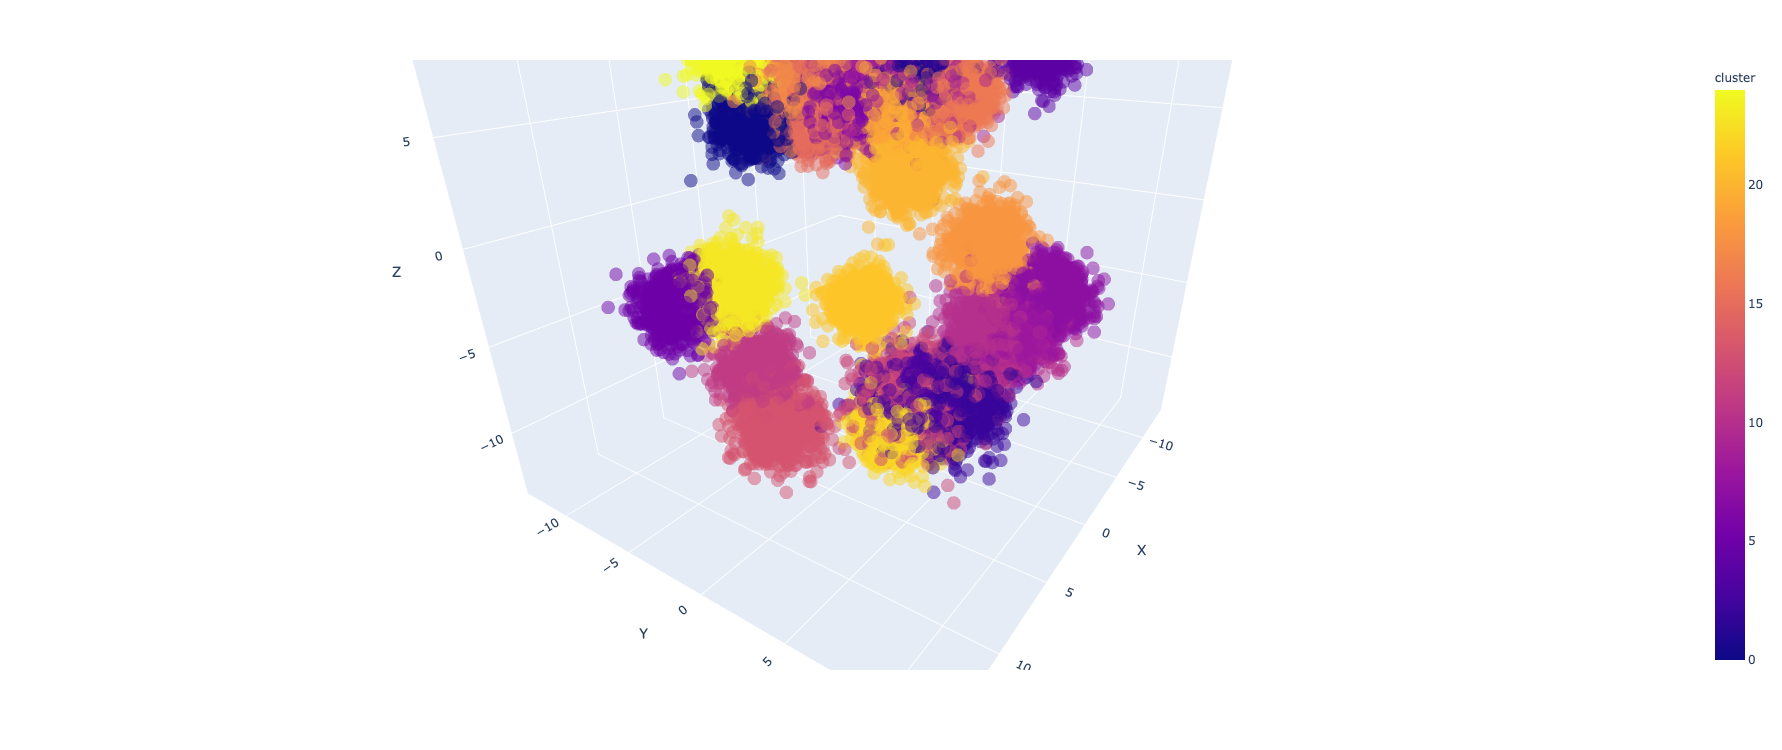

In [44]:
# Fancier 3D viz
import plotly.express as px
df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])
df['cluster'] = y
df['protein'] = fixed_proteins.protein
fig = px.scatter_3d(df, x='X', y='Y', z='Z', 
                    color='cluster', width=1000, 
                    height=750, opacity=0.5, 
                    hover_data=['protein', 'cluster', 'X', 'Y', 'Z'])
fig.show()

In [46]:
# WARNING: Re-running this as-is will result in the same random control data being overwritten
#          in GCS. That's OK. HOWEVER, if you changed the random_seed value, you WILL OVERWRITE
#          OUR CANONICAL CONTROL DATA in GCS. This is annoying because you may now have to re-run
#          the BLAST reports for new combinations of proteins we didn't see under the original
#          random seed. Also it'll make comparing model performance across our embeddings very
#          confusing.

# Append cluster labels and random proteins to X; sort by cluster label
random.seed(random_seed)
shuffled_filenames = fixed_proteins.protein.values.copy()
random.shuffle(shuffled_filenames)
control_data = np.append(X, y.reshape((len(y),1)), axis=1)
control_data = np.append(control_data, np.array(shuffled_filenames).reshape(len(fixed_proteins), 1), axis=1)
control_data = control_data[np.argsort(control_data[:, 3])]

# Save to local and GCS
pd.DataFrame(control_data, columns=['X', 'Y', 'Z', 'cluster_label', 'protein']).to_csv('random_control_clusters.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("clusters/random_control_clusters.csv", bucket)
with open('random_control_clusters.csv', "rb") as my_file:
     blob.upload_from_file(my_file)
print(f'Random control cluster data saved to GCS.')

Random control cluster data saved to GCS.


## Helper Functions to Run BLAST & Process / Upload Data

In [19]:
def get_protein_sequence(selection=None, local=False):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    dl_path = 'local_cifs/'
    
    if selection is None:
        selection = filenames

    for file in selection:
        data=[]
        # load from remote if local=True, else from local
        if local is False:
            
            blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.cif.gz')
            blob.download_to_filename(alias)

            with gzip.open(alias) as f:
                file_content = f.read()
                
            txt = io.StringIO(file_content.decode("utf-8"))
        else:
            with open(dl_path + file + '.cif', 'r') as f:
                file_content = f.read()
            txt = io.StringIO(file_content)
        
        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        block = data[0]
        obj = block.get_object("struct_ref")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        if local is False:
            txt.close()
            os.remove(alias)

    #print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.append(np.array(selection).reshape((len(result),1)), result[:,7].reshape((len(result),1)), axis=1) #result[:,5].reshape((len(result),1))
    clear_output()
    return result

In [20]:
def sequences_to_fasta(sequences, filename='tmp.fasta'):
    f = open(filename, "w")

    for protein, sequence in sequences:
        sequence = sequence.replace('\n', '')
        f.write(f'>{protein}')

        for pos in range(len(sequence)):
            if pos % 60 == 0:
                f.write('\n')
            f.write(sequence[pos])

        f.write('\n')

    f.close()
    #print(f'{len(sequences)} Protein sequences concatenated into tmp.fasta.')

In [21]:
def process_report(filename='results.out'):
    parser = SearchIO.parse(filename, "blast-tab")
    num_queries = len(list(parser))
    parser = SearchIO.parse(filename, "blast-tab")

    formatted_data = []

    for queries in range(num_queries):
        result = next(parser)
        for hsp in result.hsps:
            # ignore self-matches
            if result.id != hsp.hit_id:
                formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])

    return formatted_data


def append_annotations(new_annotations):
    if not os.path.exists('blast_annotations.csv'):
        pd.DataFrame(None, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations.csv', index=False)
    
    pd.DataFrame(new_annotations, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations.csv', index=False, mode='a', header=False)
    bucket = storage_client.get_bucket('capstone-fall21-protein')
    blob = Blob("annotations/blast_annotations.csv", bucket)
    with open('blast_annotations.csv', "rb") as my_file:
         blob.upload_from_file(my_file)

def get_gcs_annotations():
    bucket = storage_client.get_bucket('capstone-fall21-protein')
    blob = Blob("annotations/blast_annotations.csv", bucket)
    blob.download_to_filename('blast_annotations.csv')

In [23]:
def download_cifs():
    dl_path = 'local_cifs/'
    total = len(filenames)
    i = 0

    for file in filenames:
        i += 1
        print(f'{i} of {total}')
        data=[]
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.cif.gz')
        blob.download_to_filename(file + '.cif.gz')
        with gzip.open(file + '.cif.gz') as f:
            file_content = f.read()
        f = open(dl_path + file + '.cif', "w")
        f.write(file_content.decode("utf-8"))
        f.close()
        os.remove(file + '.cif.gz')
        clear_output()

In [27]:
def download_pdbs():
    path = 'UP000005640_9606_HUMAN/pdb/'
    dl_path = 'local_pdbs/'
    total = len(filenames)
    i = 0

    for file in filenames:
        i += 1
        print(f'{i} of {total}')
        data=[]
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.pdb.gz')
        blob.download_to_filename(file + '.pdb.gz')
        with gzip.open(file + '.pdb.gz') as f:
            file_content = f.read()
        f = open(dl_path + file + '.pdb', "w")
        f.write(file_content.decode("utf-8"))
        f.close()
        os.remove(file + '.pdb.gz')
        clear_output()

## Run BLAST on Remote Data + Upload on Control Random Clusters

In [123]:
# Iterate through each cluster and BLAST member proteins.
# Write entire space's BLAST scores to GCS annotations folder

# WARNING: BE VERY CAREFUL BEFORE RUNNING THIS. If you do not have the latest full annotations
#          file from GCS, this code will create a new blank one locally, append your session's
#          BLAST results, and then OVERWRITE the current full annotations file in GCS.
#          If in doubt, run get_gcs_annotations() first to pull the latest one from GCS, and
#          then run your code to APPEND to it.

# get_gcs_annotations()

for cluster_label in np.unique(control_data[:,3]):
    cluster_proteins = control_data[control_data[:,3] == cluster_label][:,4]
    cluster_sequences = get_protein_sequence(cluster_proteins)
    sequences_to_fasta(cluster_sequences)
    
    !./blast/bin/makeblastdb -in tmp.fasta -parse_seqids -blastdb_version 5 -dbtype prot
    !./blast/bin/blastp -db tmp.fasta -query tmp.fasta -out results.out -outfmt 6
    
    append_annotations(process_report())
    clear_output()

## Run BLAST on Full 23K Dataset (Only Local)

In [59]:
# Uncomment next line only if you need to download all mmCIFs again
#download_cifs()
z = get_protein_sequence(filenames, local=True)
sequences_to_fasta(z, 'tmp_full.fasta')

!./blast/bin/makeblastdb -in tmp_full.fasta -parse_seqids -blastdb_version 5 -dbtype prot
!./blast/bin/blastp -db tmp_full.fasta -query tmp_full.fasta -out results_full.out -outfmt 6
    
k = process_report('results_full.out')
append_annotations(k)



Building a new DB, current time: 09/28/2021 07:07:32
New DB name:   /home/jupyter/pss/tmp_full.fasta
New DB title:  tmp_full.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/jupyter/pss/tmp_full.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 23391 sequences in 0.949086 seconds.




## Post-Processing & Upload to GCS

In [83]:
ultra_annotations = pd.read_csv('blast_annotations.csv')
len(ultra_annotations)

7901445

In [77]:
(ultra_annotations.drop_duplicates()).to_csv('blast_annotations_dedup.csv', index=False)
df = pd.read_csv('blast_annotations_dedup.csv')
print(len(df))
print(df.head())

7901445
           query_protein         target_protein  bitscore  evalue
0  AF-Q16890-F1-model_v1  AF-P61421-F1-model_v1      20.0    0.19
1  AF-Q16890-F1-model_v1  AF-P61421-F1-model_v1      18.5    0.61
2  AF-Q16890-F1-model_v1  AF-Q02083-F1-model_v1      17.3    1.30
3  AF-Q16890-F1-model_v1  AF-Q92567-F1-model_v1      16.2    2.80
4  AF-Q92567-F1-model_v1  AF-Q02083-F1-model_v1      17.7    1.30


In [78]:
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("annotations/blast_annotations.csv", bucket)
with open('blast_annotations_dedup.csv', "r") as my_file:
    blob.upload_from_file(my_file)

## Re-Run Full BLAST and Save to GCS on Fixed Sequence Data from Skyler

In [11]:
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("structure_files/sequences/sequences.parquet", bucket)
blob.download_to_filename('sequences.parquet')
fixed_seq = pd.read_parquet('sequences.parquet')
fixed_seq.drop(['db_code', 'db_name', 'protein_name'], axis=1, inplace=True)
fixed_seq.columns = ['protein', 'sequence']
fixed_seq.head()

protein                                           sequence
0  A0A024R1R8  MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...
1  A0A024RBG1  MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
2  A0A024RCN7  MERSFVWLSCLDSDSCNLTFRLGEVESHACSPSLLWNLLTQYLPPG...
3  A0A075B6H5  METVVTTLPREGGVGPSRKMLLLLLLLGPGSGLSAVVSQHPSRVIC...
4  A0A075B6H7  MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...

In [27]:
sequences_to_fasta(fixed_seq.values, 'tmp_full.fasta')

!./blast/bin/makeblastdb -in tmp_full.fasta -parse_seqids -blastdb_version 5 -dbtype prot
!./blast/bin/blastp -db tmp_full.fasta -query tmp_full.fasta -out results_full.out -outfmt 6 -max_target_seqs 21000 -num_threads 8
    
k = process_report('results_full.out')
append_annotations(k)



Building a new DB, current time: 09/29/2021 18:46:17
New DB name:   /home/jupyter/pss/tmp_full.fasta
New DB title:  tmp_full.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/jupyter/pss/tmp_full.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 20504 sequences in 0.772448 seconds.




# Plots on Full Annotations

In [163]:
m = pd.read_csv('blast_annotations.csv').sort_values(['bitscore', 'evalue'], ascending=[False, True])
len(m)

7791727

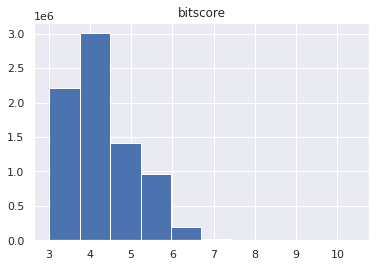

In [34]:
m[['bitscore']].apply(np.log).hist();

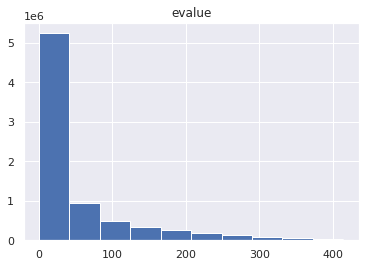

In [35]:
m[['evalue']][m.evalue > 0].apply(np.log).apply(np.abs).hist();

## Control Cluster-Level BLAST Statistics

In [181]:
pairwise_metrics = pd.read_csv('blast_annotations.csv')
clusters = pd.read_csv('random_control_clusters.csv')

# Find all combinations of proteins WITHIN clusters
all_combos = pd.DataFrame()

for clust in clusters.cluster_label.unique():
    clust_combos = pd.DataFrame(itertools.product(clusters[clusters.cluster_label == clust].protein, repeat=2), columns=['query_protein', 'target_protein'])
    clust_combos = clust_combos[clust_combos.query_protein != clust_combos.target_protein]
    clust_combos['cluster'] = clust
    all_combos = all_combos.append(clust_combos)
    
# LEFT JOIN with pairwise metrics
result = all_combos.set_index(['query_protein','target_protein']).join(pairwise_metrics.set_index(['query_protein','target_protein']), 
                                                                       on=['query_protein', 'target_protein'], 
                                                                       how='left'
                                                                      ).reset_index()

# Calculate the stats BY CLUSTER, write locally and upload to GCS
# WARNING: Replaces entire file (does not append) at the moment
stats_by_cluster = pd.DataFrame(columns=['embedding', 'model', 'cluster', 'bitscore_mean', 'bitscore_std_dev', 'evalue_mean', 'evalue_std_dev', 'ratio_pairs_wo_blast'])
work = pd.DataFrame()
print('cluster / len left join / nulls from join / all combos / ratio of nulls')
for clust in result.cluster.unique():
    slc = result[result.cluster == clust]
    
    num_combos_in_clust = len(all_combos[all_combos.cluster == clust])
    num_null_blast_combos = len(slc[slc.bitscore.isnull()])
    print(clust, len(slc), num_null_blast_combos, num_combos_in_clust, num_null_blast_combos / num_combos_in_clust)
    work = slc
    
    stats_by_cluster.loc[len(stats_by_cluster)] = ['control', 'random_gaussian', clust,  slc.bitscore.mean(), slc.bitscore.std(), slc.evalue.mean(), slc.evalue.std(), num_null_blast_combos / num_combos_in_clust]

stats_by_cluster.to_csv('run_stats.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("run_stats.csv", bucket)
with open('run_stats.csv', "r") as my_file:
    blob.upload_from_file(my_file)
#stats_by_cluster.head(25)

cluster / len left join / nulls from join / all combos / ratio of nulls
0.0 679109 670368 673220 0.9957636433855204
1.0 681730 670336 673220 0.9957161106324827
2.0 679903 670117 673220 0.9953908083538814
3.0 679052 670626 673220 0.9961468762068864
4.0 677451 668312 671580 0.9951338634265463
5.0 679000 667967 671580 0.9946201494981983
6.0 680912 668290 671580 0.9951011048572024
7.0 678313 667990 671580 0.9946543970934215
8.0 678871 668465 671580 0.9953616843860746
9.0 680681 668752 671580 0.9957890348134251
10.0 676194 668515 671580 0.9954361356800381
11.0 684572 667855 671580 0.99445337859972
12.0 682234 668516 671580 0.9954376247059173
13.0 677187 668227 671580 0.9950072962268084
14.0 677070 668927 671580 0.9960496143422972
15.0 679475 668543 671580 0.9954778284046577
16.0 676330 669035 671580 0.9962104291372584
17.0 682892 667525 671580 0.993962000059561
18.0 679338 669062 671580 0.9962506328359987
19.0 691594 667695 671580 0.9942151344590369
20.0 680072 668049 671580 0.9947422496202

In [196]:
#24
print(len(all_combos[all_combos.cluster == 24]))
print(len(result[result.cluster == 24]))
print(len(work))

671580
679643
679643


In [241]:
#all_combos[all_combos.cluster == 24][['query_protein','target_protein']] != result[result.cluster == 24][['query_protein','target_protein']]

print(len(all_combos[all_combos.cluster == 24][['query_protein', 'target_protein']]))
print(len(result[result.cluster == 24][['query_protein', 'target_protein']]))

z = all_combos[all_combos.cluster == 24].query_protein + '_' + all_combos[all_combos.cluster == 24].target_protein
d = result[result.cluster == 24].query_protein + '_' + result[result.cluster == 24].target_protein + '_' + result[result.cluster == 24].bitscore.apply(str)

671580
679643


In [238]:
print(len(z.unique()))
print(len(d.unique()))
print(len(d.unique()) - len(z.unique()))

671580
677465
5885


In [249]:
d = result[result.cluster == 24].query_protein + '_' + result[result.cluster == 24].target_protein
len(d[d.duplicated()])

8063

In [246]:
j = result[result.cluster == 24]
j[j.query_protein == j.target_protein]

Empty DataFrame
Columns: [query_protein, target_protein, cluster, bitscore, evalue]
Index: []

# TM-Align

Because RMSD is calculated as an average of distance error with equal weight over all residue pairs, a large local error on a few residue pairs can result in a quite large RMSD. On the other hand, by putting length in the denominator, TM-score naturally weights smaller distance errors more strongly than larger distance errors. Therefore, TM-score value is more sensitive to the global structural similarity rather than to the local structural errors, compared to RMSD. Another advantage of TM-score is the introduction of a scale which makes the magnitude of TM-score length-independent for random structure pairs, while RMSD and most other measures are length-dependent metrics. (Wikipedia)

Scores below 0.17 correspond to randomly chosen unrelated proteins whereas structures with a score higher than 0.5 assume generally the same fold in SCOP/CATH. (Zhang)

Quantitative study shows that proteins of TM-score = 0.5 have a posterior probability of 37% in the same CATH topology family and of 13% in the same SCOP fold family. The probabilities increase rapidly when TM-score > 0.5. (Wikipedia)

In [76]:
# compile TMAlign
!g++ -static -O3 -ffast-math -lm -o tmalign/TMalign tmalign/TMalign.cpp

In [214]:
# prod env vars
raw_path = 'local_pdbs/'
merged_path = 'merged_pdbs/'
final_path = 'final_pdbs/'

# test env vars
#raw_path = 'tmalign/'
#merged_path = 'tmalign/merged/'
#final_path = 'tmalign/final/'

In [215]:
# takes a merged pdb (or a stand-alone one) from local_pdbs/ and fixes:
#  - sequence procession number
#  - atom procession number
#  - terminator
# produces a cleaned file in final_pdbs/
def process_merged_pdb(filename):
    #with open(f'local_pdbs/{filename}.pdb') as f:
    with open(f'{merged_path}{filename}.pdb') as f:
        content = f.readlines()

    seq_index = 0
    atom_index = 0
    fixed = []

    for line in content:
        elements = line.split()
        if elements[0] == 'SEQRES':
            seq_index += 1
            line = line.replace(line[6:10], str(seq_index).rjust(4, ' '))
        elif elements[0] == 'ATOM':
            atom_index += 1
            line = line.replace(line[4:11], str(atom_index).rjust(7, ' '))
        elif elements[0] == 'TER':
            line = line.replace(line[16:26], content[content.index(line)-1][16:26])
            line = line.replace(line[3:11], str(atom_index).rjust(8, ' '))
        fixed.append(line)
    f.close()

    f = open(f"{final_path}{filename}.pdb", "w")
    for line in fixed:
        f.write(line)
    f.close()    

In [216]:
# takes 2 protein names and their tmalign report
# produces a np array with tmalign stats
def process_payload(p1, p2, pld):
    aligned_length, rmsd, tm_score_norm_ref_p1, p1_length, p2_length = 0,0,0,0,0
    result = []
    for line in pld:
        if 'Aligned length' in line:
            bits = line.split(',')
            aligned_length = int(''.join([n for n in bits[0] if n in '.0123456789']))
            rmsd = float(''.join([n for n in bits[1] if n in '.0123456789']))
        if 'normalized by length of Chain_1' in line:
            bits = line.split('=')
            tm_score_norm_ref_p1 = float(''.join([n for n in bits[1][:10] if n in '.0123456789']))
        if 'Length of Chain_1' in line:
            p1_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
        if 'Length of Chain_2' in line:
            p2_length = int(''.join([n for n in line[18:] if n in '.0123456789']))
    result = np.array([p1, p1_length, p2, p2_length, aligned_length, rmsd, tm_score_norm_ref_p1]).reshape((1, 7))
    return result

In [ ]:
# code to merge single proteins with multiple pdb files goes here
# results into local_pdbs/

# download all pdbs from GCS (only need to run this once)
path = 'UP000005640_9606_HUMAN/pdb/'
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if path in blob.name:
        filenames.append(blob.name[27:].split('.')[0])
print(f'Indexed {len(filenames)} files.')
#download_pdbs() # dangerous line



In [ ]:
dir_files = [n.split('.')[0] for n in os.listdir(raw_path) if not n in ['.ipynb_checkpoints', 'TMalign', 'TMalign.cpp']]
dir_files.sort()

df = pd.DataFrame(dir_files, columns=['file']).file.str.split(pat='-', expand=True)

dfg = df[[0,1]].groupby(1).count().reset_index()
multi_file_proteins = dfg[dfg[0] > 1][1].values
single_file_proteins = dfg[dfg[0] == 1][1].values
len_multi = len(multi_file_proteins)
len_single = len(single_file_proteins)
counter = 0

def extract_part(afile, part='SEQRES'):
    payload = []
    with open(f'{raw_path}{afile}.pdb') as f:
        content = f.readlines()
    for line in content:
        elements = line.split()
        if elements[0] == part:
            payload.append(line)
    f.close()
    return payload

for protein in multi_file_proteins:
    seqs = []
    atoms = []
    terminator = []
    fileset = df[df[1] == protein]
    plane = ['CRYST1    1.000    1.000    1.000  90.00  90.00  90.00 P 1                      \n',
            'ORIGX1      1.000000  0.000000  0.000000        0.00000                         \n',
            'ORIGX2      0.000000  1.000000  0.000000        0.00000                         \n',
            'ORIGX3      0.000000  0.000000  1.000000        0.00000                         \n',
            'SCALE1      1.000000  0.000000  0.000000        0.00000                         \n',
            'SCALE2      0.000000  1.000000  0.000000        0.00000                         \n',
            'SCALE3      0.000000  0.000000  1.000000        0.00000                         \n',
            'MODEL        0                                                                  \n']
    end = ['ENDMDL                                                                          \n',
            'END                                                                             \n']

    x = fileset.to_string(header=False, index=False,index_names=False).split('\n')
    filenames = ['-'.join(ele.split()) for ele in x]
    
    for file in filenames:
        seqs.extend(extract_part(file, 'SEQRES'))
        atoms.extend(extract_part(file, 'ATOM'))
        terminator.extend(extract_part(file, 'TER'))
    
    with open(f"{raw_path}{filenames[0]}.pdb") as f:
        source = f.readlines()
    target = open(f"{merged_path}{filenames[0]}.pdb", "w")
    
    for line in source:
        elements = line.split()
        if elements[0] != 'SEQRES':
            target.write(line)
        else:
            break
    [target.write(n) for n in seqs]
    [target.write(n) for n in plane]
    [target.write(n) for n in atoms]
    [target.write(n) for n in terminator[0]]
    [target.write(n) for n in end]
    target.close()
    
    counter += 1
    if counter % 5 == 0:
        clear_output()
    print(counter, '/', len_multi, 'Merged')

counter = 0
for protein in single_file_proteins:
    x = df[df[1] == protein].to_string(header=False, index=False,index_names=False).split('\n')
    filename = ['-'.join(ele.split()) for ele in x]
    shutil.copy2(f'{raw_path}{filename[0]}.pdb', final_path)
    counter += 1
    if counter % 5 == 0:
        clear_output()
    print(counter, '/', len_single, 'Copied')

In [218]:
# process all merged pdbs
for prot in [n.split('.')[0] for n in os.listdir(merged_path) if n not in ['.ipynb_checkpoints', 'TMalign', 'TMalign.cpp', 'merged']]:
    process_merged_pdb(prot)

In [ ]:
# generates protein combinations, runs tmalign on each, and saves results into a df
dir_files = [n.split('.')[0] for n in os.listdir(final_path) if n != '.ipynb_checkpoints']
lookup = itertools.product(dir_files, repeat=2)
total = (len(dir_files)**2)-len(dir_files)
counter = 0
result = pd.DataFrame(None, columns=['query_protein', 'query_protein_length', 'target_protein', 
                                     'target_protein_length', 'aligned_length', 'rmsd', 'tm_score_norm_ref_p1'])
for combo in lookup:
    if combo[0] != combo[1]:
        counter += 1
        cmd = f'/home/jupyter/pss/tmalign/TMalign /home/jupyter/pss/{final_path}{combo[0]}.pdb /home/jupyter/pss/{final_path}{combo[1]}.pdb'
        payload = os.popen(cmd).readlines()
        result = result.append(pd.DataFrame(process_payload(combo[0], combo[1], payload), columns=result.columns))
        if counter % 5 == 0:
            clear_output()
        print(counter, '/', total, 'Processed')
    # save every 100 pairs (just in case it fails midway)
    if counter != 0 and counter % 100 == 0:
        table = pa.Table.from_pandas(result)
        pq.write_table(table, 'tmalign_rmsd_full.parquet')
        print('Partial Results Saved')

# save whole dataset
table = pa.Table.from_pandas(result)
pq.write_table(table, 'tmalign_rmsd_full.parquet')
print('Full Results Saved')

26340 / 420393512 Processed
26341 / 420393512 Processed
26342 / 420393512 Processed
26343 / 420393512 Processed
26344 / 420393512 Processed


In [213]:
pd.read_parquet('tmalign_rmsd_full.parquet')

query_protein query_protein_length             target_protein  \
0      AF-O95071-F1-model_v1                11199  AF-A0A024R1R8-F1-model_v1   
0      AF-O95071-F1-model_v1                11199  AF-A0A075B6K0-F1-model_v1   
0  AF-A0A024R1R8-F1-model_v1                   64      AF-O95071-F1-model_v1   
0  AF-A0A024R1R8-F1-model_v1                   64  AF-A0A075B6K0-F1-model_v1   
0  AF-A0A075B6K0-F1-model_v1                  115      AF-O95071-F1-model_v1   
0  AF-A0A075B6K0-F1-model_v1                  115  AF-A0A024R1R8-F1-model_v1   

  target_protein_length aligned_length  rmsd tm_score_norm_ref_p1  
0                    64             58   3.1              0.00511  
0                   115            111  4.49              0.00963  
0                 11199             58   3.1              0.60029  
0                   115             40  4.11              0.31584  
0                 11199            111  4.49              0.52507  
0                    64             40  4.11              0.21803

# Scratch

# RMSD

In [ ]:
!pip install rmsd
import rmsd

In [ ]:
a_atoms = pd.DataFrame(get_atoms(['UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-model_v1.cif.gz']), columns=['X', 'Y', 'Z', 'protein'])
b_atoms = pd.DataFrame(get_atoms(['UP000005640_9606_HUMAN/cif/AF-A0A024RBG1-F1-model_v1.cif.gz']), columns=['X', 'Y', 'Z', 'protein'])

In [ ]:
a = np.array(a_atoms[['X', 'Y', 'Z']].astype(float).values)
b = np.array(b_atoms[['X', 'Y', 'Z']][:496].astype(float).values)

rmsd.rmsd(a, b)

# only works for 2 proteins with the same number of atoms (array lengths)
# better to use tmalign which finds subsets of alignments and gives you RMSD for that (in addition to tmalign score)

## BLAST Example

In [ ]:
# First download and unpack BLAST+ (linux x86) at /home/jupyter/pss/blast/
# Make sure /home/jupyter/pss/blast/bin/* has been chmod 777'd

# Create two sequence files
seq1 = SeqRecord(Seq(cluster_1_sequences[0][1]), id=cluster_1_sequences[0][0])
seq2 = SeqRecord(Seq(cluster_1_sequences[1][1]), id=cluster_1_sequences[1][0])
SeqIO.write(seq1, "seq1.fasta", "fasta")
SeqIO.write(seq2, "seq2.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastpCommandline(query="seq1.fasta", subject="seq2.fasta", outfmt=5)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

# The BLAST E-value is the number of expected hits of similar quality (score)
# that could be found just by chance. E-value of 10 means that up to 10 hits can
# be expected to be found just by chance, given the same size of a random
# database. The lower the E-value, or the closer it is to zero, the more 
# "significant" the match is.

# The bit score, S', is derived from the raw alignment score, S, taking the
# statistical properties of the scoring system into account. Because bit scores 
# are normalized with respect to the scoring system, they can be used to compare
# alignment scores from different searches. Higher is better, but after 50 there
# is little added statistical benefit.

for alignment in blast_result_record.alignments:
    for hsp in alignment.hsps:
        print('****Alignment****')
        print('sequence:', alignment.title)
        print('length:', alignment.length)
        print('e value:', hsp.expect)
        print('score:', hsp.score)
        #print(hsp.query)
        #print(hsp.match)
        #print(hsp.sbjct)

## Test BLAST Parameters on Small Query (Target)

In [263]:
# -outfmt 6 means tab-delimited; corresponding param for SearchIO.parse is "blast-tab"
!./blast/bin/blastp -db tmp.fasta -query tmp_test.fasta -out results_test.out -outfmt 6

In [264]:
parser = SearchIO.parse("results_test.out", "blast-tab")
num_queries = len(list(parser))
parser = SearchIO.parse("results_test.out", "blast-tab")

formatted_data = []

for queries in range(num_queries):
    result = next(parser)
    for hsp in result.hsps:
        formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])

In [265]:
pd.DataFrame(formatted_data, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations_test.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
my_file.upload_from_file(open('blast_annotations_test.csv'))

## Atom Cartesian Coordinate Clustering (see [`protein_eda`](protein_eda.ipynb) Notebook)

In [89]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(14,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## How to Write Parquet Files

In [177]:
table = pa.Table.from_pandas(pd.DataFrame(r[:5]))
pq.write_table(table, 'repr_random.parquet')

## Proof of Concept for Randomly Sampling Proteins, Unzipping & Processing

In [ ]:
data=[]
stats = [0, 0]
result = []
alias = 'tmp.cif.gz'

for file in random.sample(filenames, 10):
    blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
    blob.download_to_filename(alias)

    with gzip.open(alias) as f:
        file_content = f.read()

    txt = io.StringIO(file_content.decode("utf-8"))

    stats[0] += 1
    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")

    for row in obj.get()[2]:
        result.append(row)

    stats[1] += len(obj.get()[2])

os.remove(alias)
print(f'Processed {stats[0]} proteins ({stats[1]} rows).')

In [ ]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(10)

## Get Atoms

In [43]:
def get_atoms(selection=None):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    
    if selection is None:
        selection = filenames
    
    for file in selection:
        data = []
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
        blob.download_to_filename(alias)

        with gzip.open(alias) as f:
            file_content = f.read()

        txt = io.StringIO(file_content.decode("utf-8"))

        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        txt.close()

        block = data[0]
        obj = block.get_object("atom_site")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        os.remove(alias)
    
    print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.column_stack((result[:,10:13], result[:,21]))
    return result

In [ ]:
cluster_1_atoms = get_atoms(['UP000005640_9606_HUMAN/cif/AF-A0A024R1R8-F1-model_v1.cif.gz'])
atoms = pd.DataFrame(cluster_1_atoms, columns=['X', 'Y', 'Z', 'protein'])
atoms

## Misc.